In [5]:
import pandas as pd
import geopandas as gpd
import numpy as np
import math
import matplotlib.pyplot as plt
import shapely.geometry as geom
from shapely.geometry import Point, Polygon, LineString, GeometryCollection, MultiPolygon
from shapely.ops import split
from shapely.errors import GEOSException


In [913]:
blocks = gpd.read_file('my_blooks_2.geojson')
# Перепроецируем 
blocks = blocks.to_crs('EPSG:32636')
blocks['area'] = blocks['geometry'].area
idat_max = 10
idat_min = 0

In [914]:
# Максимальная зона влияния
blocks['zone_area_max'] = 10 * blocks['area'] * (1 + (10-idat_min)/ (idat_max - idat_min))

# Заолняем пустые значения нулями
blocks['zone_area'] = blocks['zone_area'].fillna(0)

# Выбираем только те блоки, где площадь влияние больше 0
blocks_idat = blocks[blocks['zone_area'] > 0].reset_index()

# Меняем кварталы на точки
blocks_idat['geometry'] = blocks_idat['geometry'].centroid

# Расчитываем радиус
for i in range(len(blocks_idat)):
    blocks_idat.loc[i, 'radius'] = math.sqrt(blocks_idat.loc[i, 'zone_area'] / math.pi)
    blocks_idat.loc[i, 'radius_max'] = math.sqrt(blocks_idat.loc[i, 'zone_area_max'] / math.pi)

# Строим текущую зону влияния
blocks_idat['geometry'] = blocks_idat['geometry'].buffer(blocks_idat['radius'])

In [ ]:
def perpendicular_creator(p1, p2,midpoint, length=100):
    linestring = LineString([p1, p2])
    # Получение координат концов линии
    p1 = linestring.coords[0]
    p2 = linestring.coords[-1]
    
    # Направляющий вектор исходного отрезка
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    
    # Нормальный вектор (перпендикулярный направляющему вектору)
    normal_dx = -dy
    normal_dy = dx
    
    # Длина нормального вектора
    norm_length = (normal_dx**2 + normal_dy**2)**0.5
    
    # Масштабируем нормальный вектор до нужной длины
    scaled_normal_dx = normal_dx / norm_length * length / 2
    scaled_normal_dy = normal_dy / norm_length * length / 2
    
    # Координаты начала и конца перпендикуляра
    start_point = (midpoint.x - scaled_normal_dx, midpoint.y - scaled_normal_dy)
    end_point = (midpoint.x + scaled_normal_dx, midpoint.y + scaled_normal_dy)
    
    # Создаем перпендикуляр
    perpendicular = LineString([start_point, end_point])
    
    return perpendicular

def split_geometry_collection(geometry_collection):
    geometries = []
    for geom in geometry_collection.geoms:
        geometries.append(geom)
    return geometries

def divide_and_assign_intersection(polygon1, polygon2):
    # Находим пересечение полигонов
    try:
        intersection = polygon1.intersection(polygon2)
    except GEOSException:
        intersection = Point(0,0)
    
    if not intersection.is_empty and type(intersection) == Polygon:
        # Делим пересечение пополам вдоль оси X
        x_midpoint = (intersection.bounds[0] + intersection.bounds[2]) / 2
        point1 = polygon1.centroid
        point2 = polygon2.centroid
        point_intersection = intersection.centroid
        # Создаём линию
        line = perpendicular_creator(point1, point2,point_intersection, length=10000)
        #line = create_line(point1, point2, point_intersection)
        
        # Разделяем пересечение на две части
        #join_poly = polygon1.union(polygon2)
        if isinstance(intersection, GeometryCollection):
            intersection = split_geometry_collection(intersection)[0]
        parts = split(intersection, line)
        
        non_intersecting_polygon1 = polygon1.difference(polygon2)
        non_intersecting_polygon2 = polygon2.difference(polygon1)
        try: 
            len_1 = LineString([point1, (parts.geoms[0].centroid.x, parts.geoms[0].centroid.y)]).length
            len_2 = LineString([point1, (parts.geoms[1].centroid.x, parts.geoms[1].centroid.y)]).length
        except IndexError:
            len_2 = 0
        if len_2 == 0:
            new_polygon2 = non_intersecting_polygon2.union(parts)
            new_polygon1 = non_intersecting_polygon1
        else:
            if len_1 < len_2:
                new_polygon1 = non_intersecting_polygon1.union(parts.geoms[0])
                new_polygon2 = non_intersecting_polygon2.union(parts.geoms[1])
            else:
                new_polygon1 = non_intersecting_polygon1.union(parts.geoms[1])
                new_polygon2 = non_intersecting_polygon2.union(parts.geoms[0])

        return new_polygon1, new_polygon2
    else:

        return polygon1, polygon2
    
def process_geometry(polygon1, polygon2):
    if isinstance(polygon1, GeometryCollection):
        geometries = []
        for geom in polygon.geoms:
            geometries.append(geom)
    if isinstance(polygon2, GeometryCollection):
        geometries_2 = []
        for geom in polygon.geoms:
            geometries.append(geom)            
            for geom in polygon1.geoms:
                for geom in polygon2.geoms:
                    return(divide_and_assign_intersection(polygon1, polygon2))
        else:
            for geom in polygon1.geoms:
                return(divide_and_assign_intersection(polygon1, polygon2)) 
    elif isinstance(polygon2, GeometryCollection):
            for geom in polygon2.geoms:
                    return(divide_and_assign_intersection(polygon1, polygon2))
    else:
        return(divide_and_assign_intersection(polygon1, polygon2))
    

In [885]:
for i in blocks_idat.index:
    for j in blocks_idat[blocks_idat.index != i].index:
        blocks_idat.loc[i,'geometry'], blocks_idat.loc[j,'geometry'] = divide_and_assign_intersection(blocks_idat.loc[i,'geometry'], blocks_idat.loc[j,'geometry'])

In [886]:
blocks_idat

,index,id,land_use,is_living,build_floo,living_dem,living_are,share_livi,business_a,share_busi,...,6_norm,3_norm,IDAT,2_norm,zone_area,geometry,area,zone_area_max,radius,radius_max
0,246,246,residential,1,272232.382685,48.994230,41645.095367,0.536488,230587.287318,2.970512,...,4.0,8.0,6.5,9.5,1994361.349,"MULTIPOLYGON (((351835.878 6645244.729, 351811...",185954.438097,3.719089e+06,796.759019,1088.036176
1,1080,1080,residential,1,268006.882294,36.480506,118233.319969,1.956418,149773.562325,2.478317,...,5.0,7.0,6.0,9.5,1018860.292,"MULTIPOLYGON (((351063.648 6647658.504, 351044...",106131.280459,2.122626e+06,569.485121,821.980971
2,1084,1084,residential,1,72507.216328,34.588800,7782.480011,0.303894,64724.736317,2.527402,...,6.0,8.0,7.1,9.5,808012.577,"POLYGON ((354304.572 6645685.417, 354274.925 6...",66552.390809,1.331048e+06,507.147307,650.911422
3,1111,1111,recreation,1,50985.450256,53.993243,7991.000000,1.599951,42994.450256,8.608310,...,4.0,5.0,6.1,9.5,309045.234,"POLYGON ((346716.356 6646778.068, 346685.614 6...",31467.796946,6.293559e+05,313.643354,447.582637
4,1138,1138,residential,1,8803.970464,49.122223,442.100006,0.092584,8361.870458,1.751132,...,5.0,5.0,6.2,10.0,144715.370,"POLYGON ((352747.045 6648091.018, 352738.04 66...",14408.141206,2.881628e+05,214.626030,302.861479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147,11937,11937,residential,1,38743.518391,65.143158,20129.235840,2.103778,18614.282551,1.945445,...,4.0,8.0,7.0,9.5,248940.018,"POLYGON ((349311.259 6650108.853, 349419.106 6...",20919.329285,4.183866e+05,281.496126,364.933674
148,12142,12142,residential,1,48341.978302,32.676264,16534.189697,0.802803,31807.788605,1.544398,...,5.0,7.0,6.8,9.5,569531.035,"POLYGON ((351523.924 6649814.294, 351513.772 6...",49853.907118,9.970781e+05,425.778533,563.364740
149,12260,12260,residential,1,36757.414413,67.851635,10381.300171,1.044804,26376.114243,2.654568,...,4.0,7.0,6.2,9.5,188573.549,"POLYGON ((348920.685 6649780.175, 348926.662 6...",18774.746054,3.754949e+05,244.999643,345.722064
150,12263,12263,residential,1,36923.053650,25.271401,22946.432190,3.181404,13976.621460,1.937786,...,10.0,6.0,6.2,9.5,140147.468,"POLYGON ((349594.336 6649939.236, 349602.287 6...",13953.352032,2.790670e+05,211.211564,298.043282


In [ ]:
# Считаем какие полигоны самые большие оценки и имеют больше всего соседей
blocks_idat_clipped = blocks_idat.copy()
blocks_idat_clipped['high'] = 0
for i in range(len(blocks_idat_clipped)):
    # Геометрия выбранного полигона
    selected_polygon = blocks_idat_clipped.iloc[i].geometry

    # Находим все полигоны, которые пересекаются с выбранным
    try:
        neighbor_indices = blocks_idat_clipped.index[blocks_idat_clipped.geometry.intersects(selected_polygon)]
        # Фильтруем датафрейм, оставляя только соседние полигоны
        neighbors = blocks_idat_clipped.loc[neighbor_indices]
        index_biggest = neighbors[neighbors['IDAT'] == neighbors['IDAT'].max()].index
        blocks_idat_clipped.loc[index_biggest, 'high'] += 1
        if len(neighbors) == 1:
            blocks_idat_clipped.loc[index_biggest, 'high'] = 5
    except GEOSException:
        blocks_idat_clipped.loc[index_biggest, 'high'] += 1


In [494]:
def cutting_blocks(gdf, gdf_2):
    # Индекс выбранного полигона
    selected_index = gdf[gdf['high'] == gdf['high'].max()].index
    # У выбранного блока строим радиус, либо который посчитан, либо строим какой нам надо
    try:
        for ind in selected_index:
            gdf.loc[ind, 'geometry'] = gdf.loc[ind, 'geometry'].centroid.buffer(gdf.loc[ind, 'radius'])
            # Геометрия выбранного полигона
            selected_polygon = gdf.loc[ind].geometry

            # Находим все полигоны, которые пересекаются с выбранным
            neighbor_indices = gdf.index[gdf.geometry.intersects(selected_polygon)]
            #neighbor_indices = gdf.index[gdf.geometry.intersects(selected_polygon, align=True)]

            # Фильтруем датафрейм, оставляя только соседние полигоны
            neighbors = gdf.loc[neighbor_indices]
            gdf = gdf.drop(index = neighbors.index)
            gdf_2.loc[ind, 'geometry'] = neighbors['geometry'].union_all()
            gdf_2.loc[ind, 'checked'] = 1
    except KeyError:
        print('')
    return(gdf, gdf_2)

In [ ]:
blocks_idat_2 = blocks_idat_clipped.copy()
blocks_idat_3 = blocks_idat_clipped.copy()

for i in range(len(blocks_idat_2)):
    blocks_idat_2, blocks_idat_3 = cutting_blocks(blocks_idat_2, blocks_idat_3)

blocks_idat_3 = blocks_idat.loc[blocks_idat_3[blocks_idat_3['checked']==1].index].copy()

In [ ]:
# Ручная очистка неподходящих кварталов
blocks_idat_3 = blocks_idat_3[blocks_idat_3.index != 144]
blocks_idat_3 = blocks_idat_3[blocks_idat_3.index != 121]
blocks_idat_3 = blocks_idat_3[blocks_idat_3.index != 53]

In [831]:
# Строим максимальные буфферы
blocks_idat_3['geometry'] = blocks_idat_3['geometry'].buffer(blocks_idat_3['radius_max']) # Как максимально возможный радиус

list_to_drop = []
for i in blocks_idat_3.index:
    for j in blocks_idat_3[blocks_idat_3.index != i].index:
            blocks_idat_3.loc[i,'geometry'], blocks_idat_3.loc[j,'geometry'] = divide_and_assign_intersection(blocks_idat_3.loc[i,'geometry'], blocks_idat_3.loc[j,'geometry'])

In [835]:
blocks_idat_3['zone_area_final'] = blocks_idat_3['geometry'].area

# считаем итоговый ИДАТ
for j in blocks_idat_3.index:
    list_values = []
    for i in range(0, 101):
        value = round(i * 0.1, 1)
        if blocks_idat_3.loc[j, 'zone_area_final'] >= value * blocks_idat_3.loc[j, 'area'] * (1 + (value-idat_min)/ (idat_max - idat_min)):
            list_values.append(value)
    blocks_idat_3.loc[j,'IDAT_final'] = list_values[-1]

# Считаем индексы
blocks_idat_3['index_perfect'] = blocks_idat_3['zone_area_max'] - blocks_idat_3['zone_area_final']
blocks_idat_3['index_optimyzed'] = blocks_idat_3['zone_area_final'] - blocks_idat_3['zone_area']

# Проверка результата оптимизации
for i in blocks_idat_3.index:
    if blocks_idat_3.loc[i, 'index_optimyzed'] >= blocks_idat_3.loc[i, 'index_perfect']:
        blocks_idat_3.loc[i, 'optimixation_result'] = 1
    else:
        blocks_idat_3.loc[i, 'optimization_result'] = 0

In [872]:
index_harmony = abs(blocks_idat_3['zone_area_final'] / blocks_idat_3['zone_area_final'].sum() - 1 / len(blocks_idat_3)).sum()
print(f'Индекс гармоничности: {round(index_harmony, 3)}')

Индекс гармоничности: 0.721


In [1010]:
# Коэффициенты весомости для 11 показателей
weights = {
    'p1': 0.12, 'p2': 0.10, 'p3': 0.09, 'p4': 0.11, 'p5': 0.07, 
    'p6': 0.08, 'p7': 0.10, 'p8': 0.09, 'p9': 0.08, 'p10': 0.08, 'p11': 0.08
}
min_levels = {  # Минимально допустимые значения показателей
    'p1': 6, 'p2': 6, 'p3': 5, 'p4': 6, 'p5': 5,
    'p6': 5, 'p7': 6, 'p8': 5, 'p9': 6, 'p10': 5, 'p11': 5
}

# Функция для расчета требуемых улучшений
def calculate_improvements(fact_idat, opt_idat, current_values, min_levels):
    # Вычисляем разницу между оптимизированным и текущим ИДАТ
    delta_idat = opt_idat - fact_idat
    
    if delta_idat <= 0:
        return current_values, {}  # Если ИДАТ уже оптимизирован, улучшение не требуется
    
    # Определяем, какие показатели требуют улучшения
    to_improve = {p: current_values[p] for p in weights if current_values[p] < min_levels[p]}
    
    # Если нет показателей для улучшения, возвращаем текущие значения
    if not to_improve:
        return current_values, {}
    
    # Определяем вклад каждого показателя
    adjustment_factor = delta_idat / sum(weights[p] for p in to_improve)
    
    # Рассчитываем новые значения показателей
    improved_values = current_values.copy()
    for p in to_improve:
        improved_values[p] += adjustment_factor * weights[p]
        
    return improved_values

In [ ]:

# Применение функции для расчета требуемых улучшений
for i in blocks_idat_3.index:
    current_values = {}
    current_values['p1'] = float(blocks_idat_3.loc[i,'1_norm'])
    current_values['p2'] = float(blocks_idat_3.loc[i,'2_norm'])
    current_values['p3'] = float(blocks_idat_3.loc[i,'3_norm'])
    current_values['p4'] = float(blocks_idat_3.loc[i,'4_norm'])
    current_values['p5'] = float(blocks_idat_3.loc[i,'5_norm'])
    current_values['p6'] = float(blocks_idat_3.loc[i,'6_norm'])
    current_values['p7'] = float(blocks_idat_3.loc[i,'7_norm'])
    current_values['p8'] = float(blocks_idat_3.loc[i,'8_norm'])
    current_values['p9'] = float(blocks_idat_3.loc[i,'9_norm'])
    current_values['p10'] = float(blocks_idat_3.loc[i,'10_norm'])
    current_values['p11'] = float(blocks_idat_3.loc[i,'11_norm'])
    
    # Рассчитываем необходимые улучшения
    new_values = calculate_improvements(float(blocks_idat_3.loc[i,'IDAT']), float(blocks_idat_3.loc[i,'IDAT_final']), current_values, min_levels)
    try:
        blocks_idat_3.loc[i,'1_optimized'] = float(round(new_values['p1'],2))
    except:
        blocks_idat_3.loc[i,'1_optimized'] = float(round(new_values[0]['p1'],2))
    try:
        blocks_idat_3.loc[i,'2_optimized'] = float(round(new_values['p2'],2))
    except:
        blocks_idat_3.loc[i,'2_optimized'] = float(round(new_values[0]['p2'],2))
    try:
        blocks_idat_3.loc[i,'3_optimized'] = float(round(new_values['p3'],2))
    except:
        blocks_idat_3.loc[i,'3_optimized'] = float(round(new_values[0]['p3'],2))
    try:
        blocks_idat_3.loc[i,'4_optimized'] = float(round(new_values['p4'],2))
    except:
        blocks_idat_3.loc[i,'4_optimized'] = float(round(new_values[0]['p4'],2))
    try:
        blocks_idat_3.loc[i,'5_optimized'] = float(round(new_values['p5'],2))
    except:
        blocks_idat_3.loc[i,'5_optimized'] = float(round(new_values[0]['p5'],2))
    try:
        blocks_idat_3.loc[i,'6_optimized'] = float(round(new_values['p6'],2))
    except:
        blocks_idat_3.loc[i,'6_optimized'] = float(round(new_values[0]['p6'],2))
    try:
        blocks_idat_3.loc[i,'7_optimized'] = float(round(new_values['p7'],2))
    except:
        blocks_idat_3.loc[i,'7_optimized'] = float(round(new_values[0]['p7'],2))
    try:
        blocks_idat_3.loc[i,'8_optimized'] = float(round(new_values['p8'],2))
    except:
        blocks_idat_3.loc[i,'8_optimized'] = float(round(new_values[0]['p8'],2))
    try:
        blocks_idat_3.loc[i,'9_optimized'] = float(round(new_values['p9'],2))
    except:
        blocks_idat_3.loc[i,'9_optimized'] = float(round(new_values[0]['p9'],2))
    try:
        blocks_idat_3.loc[i,'10_optimized'] = float(round(new_values['p10'],2))
    except:
        blocks_idat_3.loc[i,'10_optimized'] = float(round(new_values[0]['p10'],2))
    try:
        blocks_idat_3.loc[i,'11_optimized'] = float(round(new_values['p11'],2))
    except:
        blocks_idat_3.loc[i,'11_optimized'] = float(round(new_values[0]['p11'],2))
    

<Axes: >

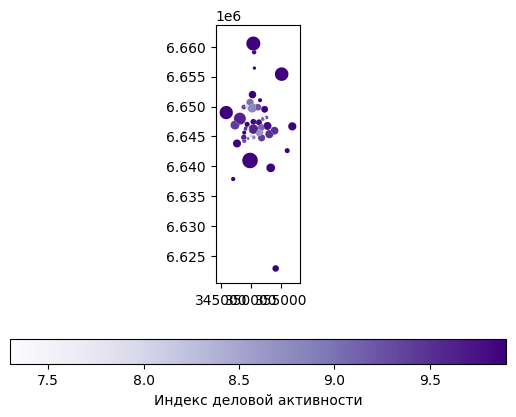

In [1008]:
blocks_idat_3.plot(column="IDAT_final",
                   legend=True,
                    legend_kwds={"label": "Индекс деловой активности", "orientation": "horizontal"},
                    cmap='Purples',
                    )

In [10]:
blocks_idat_3[['IDAT', 'IDAT_final']].head(5)

,IDAT,IDAT_final
0,7.1,9.5
1,6.2,9.2
2,6.5,9.8
3,6.0,9.9
4,6.0,9.5


In [1009]:
# Сохраняем итоговые файлы
blocks_idat_3.to_file('blocks_idat.geojson')
blocks_idat_3.to_csv('blocks_idat.csv')

In [874]:
blocks_idat_3.explore()